In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.utils import resample

In [28]:
df = pd.read_csv('pitches_final_simplified.csv', index_col = 0)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
df['game_date'].sort_values()

0          2015-04-05
205        2015-04-05
204        2015-04-05
203        2015-04-05
202        2015-04-05
              ...    
3615228    2019-10-30
3615227    2019-10-30
3615226    2019-10-30
3615233    2019-10-30
3615436    2019-10-30
Name: game_date, Length: 3615437, dtype: object

In [30]:
df.head()

,game_date,release_speed,player_name,description,zone,type,balls,strikes,plate_x,plate_z,...,pitch_name,bat_score,fld_score,reg_season,post_season,p_left,p_right,bat_left,bat_right,prev_pitch
0,2015-04-05,90.1,Adam Wainwright,ball,13,B,0,0,-1.585,1.720,...,Fastball,0,1,1,0,0,1,1,0,None
1,2015-04-05,88.1,Adam Wainwright,hit_into_play_no_out,5,X,1,0,0.008,2.602,...,Fastball,0,1,1,0,0,1,1,0,Fastball
2,2015-04-05,92.2,Adam Wainwright,foul,5,S,0,0,0.015,2.287,...,Fastball,0,1,1,0,0,1,0,1,None
3,2015-04-05,76.6,Adam Wainwright,blocked_ball,14,B,0,1,1.703,0.220,...,Breaking Ball,0,1,1,0,0,1,0,1,Fastball
4,2015-04-05,89.9,Adam Wainwright,hit_into_play,9,X,1,2,0.788,1.808,...,Fastball,0,1,1,0,0,1,0,1,Breaking Ball


In [129]:
kershaw = df[df['player_name']=='Max Scherzer']

In [130]:
# Naturally expect a class imbalance for pitchers
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

In [131]:
# Drop intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

# Unable to classify/do regression with classes with only 1 instance
# so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
for i in range(len(kershaw['pitch_name'].value_counts())):
    if kershaw['pitch_name'].value_counts()[i] == 1:
        drop = kershaw['pitch_name'].value_counts().index[i]
        kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
        kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

# Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
kershaw.drop(['release_speed'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

X = pd.concat([kershaw, balls, strikes, prev], axis = 1)
X.drop(['balls', 'strikes', 'prev_pitch'], axis = 1, inplace = True)

# X.drop(['pitch_name'], axis = 1, inplace = True)

X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

X['early'] = np.where(X['inning'] <= 3, 1, 0)
X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

X.drop(['inning'], axis = 1, inplace = True)

X.drop(['pitch_number'], axis = 1, inplace = True)

X.drop(['zone'], axis = 1, inplace = True)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [132]:
X1 = X.drop(['pitch_name'], axis = 1)
y = X['pitch_name']

In [133]:
from sklearn.model_selection import train_test_split

# Split with stratification given the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
y_test_copy = y_test.copy()

In [134]:
train = pd.concat([X_train, y_train], axis =1)

In [135]:
df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

df_down = resample(df_major, 
                      replace=True, 
                      n_samples = train['pitch_name'].value_counts().values[1], 
                      random_state=123)


df_downsampled = pd.concat([df_down, df_rest])

In [136]:
df_downsampled.columns

Index(['on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'bat_score', 'fld_score',
       'reg_season', 'post_season', 'p_left', 'p_right', 'bat_left',
       'bat_right', 'b__0', 'b__1', 'b__2', 'b__3', 's__0', 's__1', 's__2',
       'prev__Breaking Ball', 'prev__Fastball', 'prev__None',
       'prev__Off-speed', 'early', 'mid', 'late', 'pitch_name'],
      dtype='object')

In [137]:
X_train = df_downsampled.drop(['pitch_name'], axis = 1)

In [138]:
X_train.columns

Index(['on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'bat_score', 'fld_score',
       'reg_season', 'post_season', 'p_left', 'p_right', 'bat_left',
       'bat_right', 'b__0', 'b__1', 'b__2', 'b__3', 's__0', 's__1', 's__2',
       'prev__Breaking Ball', 'prev__Fastball', 'prev__None',
       'prev__Off-speed', 'early', 'mid', 'late'],
      dtype='object')

In [139]:
y_train = df_downsampled['pitch_name']
y_train.value_counts()

Fastball         3568
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64

In [140]:
# Convert output to an array
pitch = pd.get_dummies(y_train.copy())
y_train = pitch.values

In [142]:
pitch = pd.get_dummies(y_test.copy())
y_test = pitch.values

In [143]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8928, 26)
(8928, 3)
(4265, 26)
(4265, 3)


In [70]:
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum = 0.9, nesterov = False)

In [71]:
opt = tf.keras.optimizers.Adam(lr=0.0001)

***

## Optimize epochs

In [47]:
# See how the # of epochs affect accuracy
testacc = []
testloss = []
eps = np.arange(1, 76)
for i in eps:
    # Reset model every time or it will continue to run further epochs on same model
    input_layer = Input(shape = (X.shape[1], ))
    dense_layer_1 = Dense(512, activation='relu')(input_layer)
    drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
    drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
    drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
    dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
    # Output shape equals to number of classes (columns) in y
    output = Dense(y.shape[1], activation='softmax')(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    history = model.fit(X_train, y_train, batch_size=25, epochs=i, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    testloss.append(score[0])
    testacc.append(score[1])

IndexError: tuple index out of range

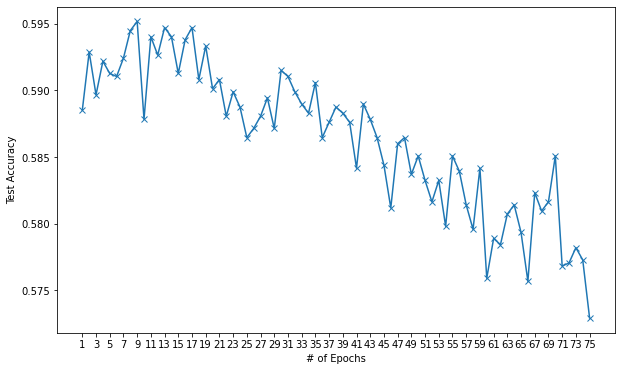

In [760]:
# Acc seems to peak at 9 but at 13 epochs, acc is similar with lower test loss
plt.figure(figsize = (10,6))
plt.plot(eps, testacc, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

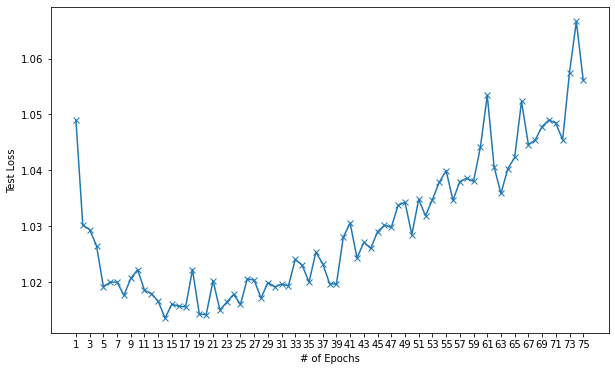

In [761]:
# Acc seems to peak at 2 epochs surprisingly
plt.figure(figsize = (10,6))
plt.plot(eps, testloss, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Loss')
plt.show()

***

In [221]:
# Want a reasonable number of epochs for running/adjusting to different pitchers

# Make sure to reset model before running each time
input_layer = Input(shape = (X_train.shape[1], ))
dense_layer_1 = Dense(512, activation='relu')(input_layer)
drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
# Output shape equals to number of classes (columns) in y
output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=25, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
286/286 [==============================] - 1s 4ms/step - loss: 0.9789 - acc: 0.4990 - val_loss: 1.1069 - val_acc: 0.4429
Epoch 2/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9423 - acc: 0.5230 - val_loss: 1.2121 - val_acc: 0.2620
Epoch 3/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9352 - acc: 0.5270 - val_loss: 1.1344 - val_acc: 0.3931
Epoch 4/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9290 - acc: 0.5297 - val_loss: 1.1619 - val_acc: 0.3427
Epoch 5/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9248 - acc: 0.5319 - val_loss: 1.1694 - val_acc: 0.3634
Epoch 6/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9217 - acc: 0.5356 - val_loss: 1.1633 - val_acc: 0.3371
Epoch 7/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9202 - acc: 0.5346 - val_loss: 1.1900 - val_acc: 0.3359
Epoch 8/30
286/286 [==============================] - 1s 3ms/step - loss: 0.

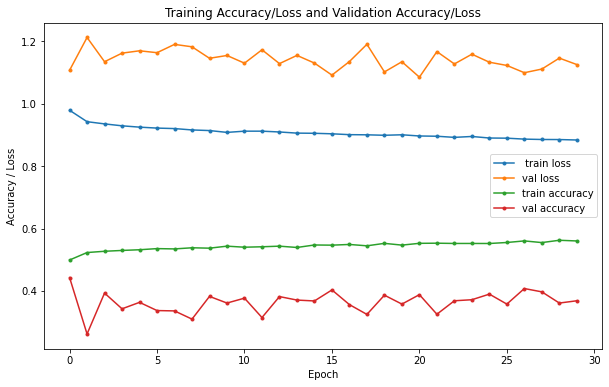

In [222]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

In [223]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

134/134 [==============================] - 0s 1ms/step - loss: 0.8900 - acc: 0.5630
Test Loss: 0.8899880051612854
Test Accuracy: 0.562954306602478


In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [224]:
predictions = model.predict(X_test)
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,630,527,33,1190
Actual_Fastball,670,1715,93,2478
Actual_Off-speed,153,388,56,597
Sum of Predictions,1453,2630,182,4265


In [219]:
# Precision: How accurate are our claims?

pfb = 1530/2380
pbb = 592/1526
pof = 97/359

sum = pfb+pbb+pof
sum

1.3009944618260276

In [226]:
# 30 epochs
# Precision: How accurate are our claims?

pfb = 1715/2630
pbb = 630/1453
pof = 56/182

sum = pfb+pbb+pof
sum

1.3933692472352488

In [220]:
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible

rfb = 1530/2478
rbb = 592/1190
ros = 97/597

sum = rfb + rbb + ros
sum

1.2773914676167717

In [225]:
# 30 epochs
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible
# TRUE POSITIVE RATE

rfb = 1715/2478
rbb = 630/1190
ros = 56/597

sum = rfb + rbb + ros
sum

1.315304505244735

In [228]:
from sklearn.metrics import f1_score

f1_score(actual_pitch, pred_pitch, average = 'weighted')

0.5432847179027874

In [231]:
actual_pitch

array([1, 0, 2, ..., 1, 1, 0], dtype=int64)

In [232]:
from sklearn.metrics import classification_report

actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.43      0.53      0.48      1190
     Fastball       0.65      0.69      0.67      2478
    Off-speed       0.31      0.09      0.14       597

     accuracy                           0.56      4265
    macro avg       0.46      0.44      0.43      4265
 weighted avg       0.54      0.56      0.54      4265



In [108]:
predictions = model.predict(X_test)
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,554,589,47,1190
Actual_Fastball,632,1718,128,2478
Actual_Off-speed,150,375,72,597
Sum of Predictions,1336,2682,247,4265


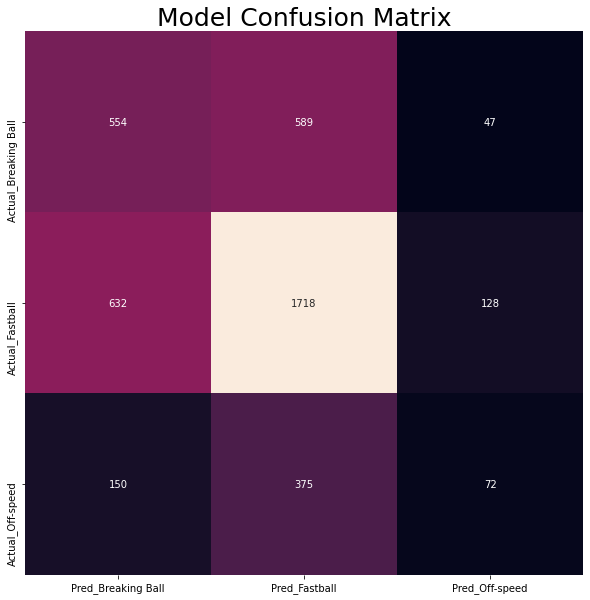

In [109]:
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns

indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]

conf_mat = confusion_matrix(actual_pitch,pred_pitch)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            xticklabels=cols,
            yticklabels=indices,
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

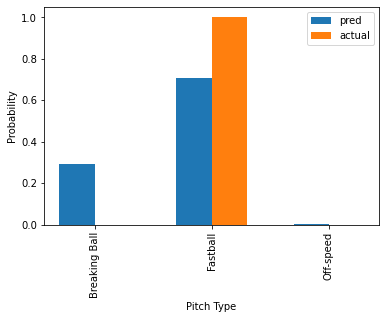

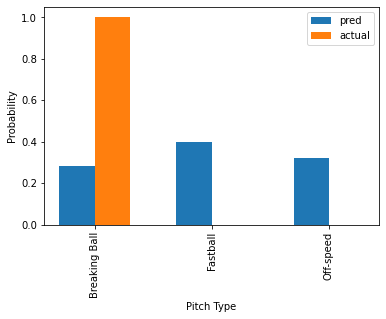

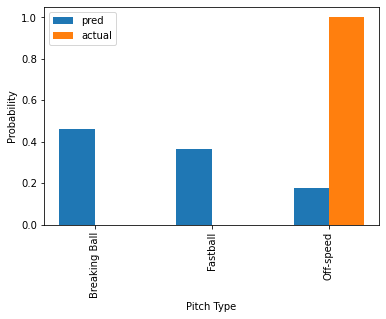

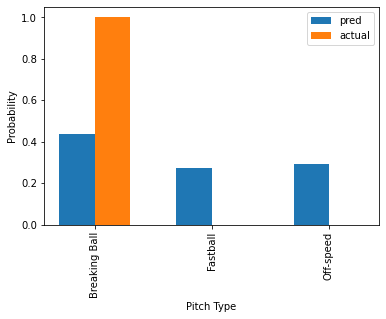

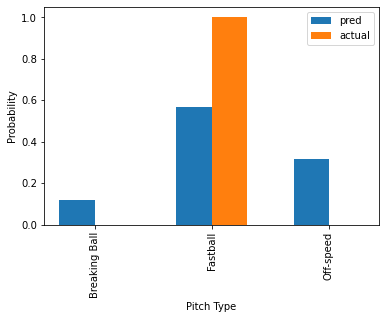

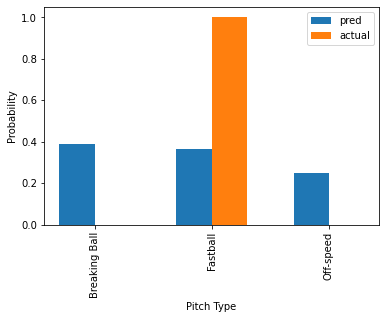

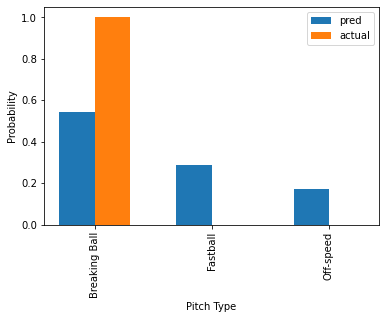

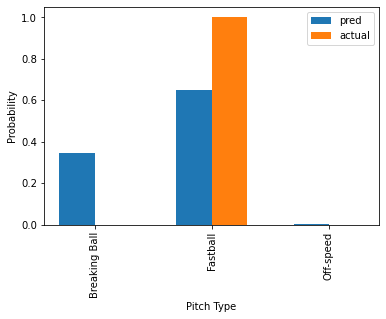

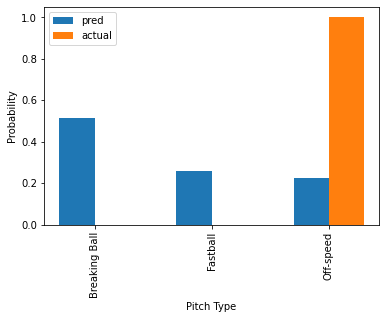

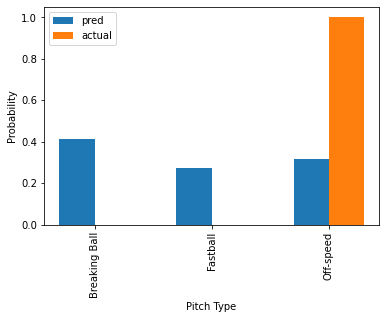

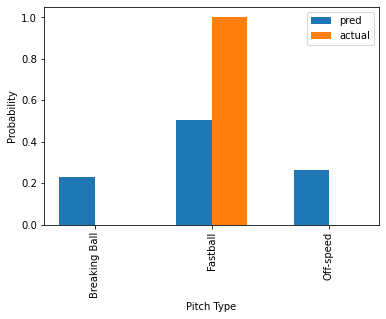

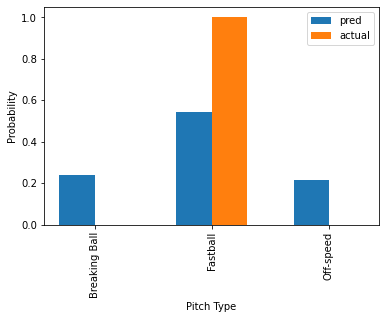

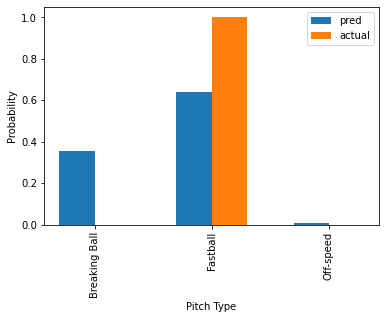

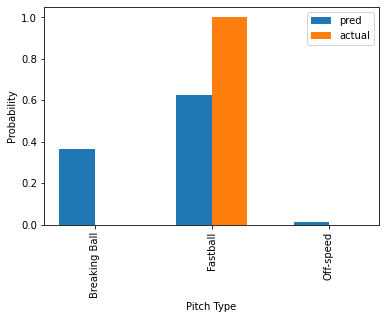

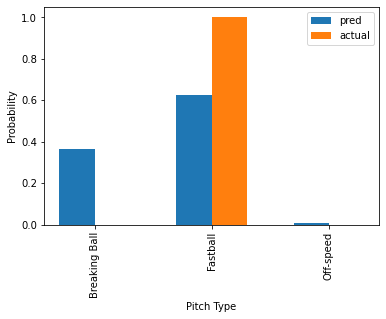

In [257]:
predictions = model.predict(X_test)

xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(15):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

In [ ]:
### Upon further thought, this is not the best baseline indicator!

fb = y_test.copy()

# Baseline accuracy if guess was ALL 4 seam fastball

# Equals a copy to not modify the original just in case
fb = y_test.copy()

# Make all elements an array that corresponds to 4S-FB
for i in range(len(fb)):
    fb[i] = np.array([0,1,0,0,0,0])

match = 0
for i in range(len(fb)):
    # Add 1 to match if the arrays correspond to 4S-FB
    if np.all(fb[i] == y_test[i]):
        match = match+1
        
# Accuracy score caluclated by matches/total
acc = match/len(fb)
acc

---

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [145]:
# Need to use different types of y values for DTree (y is not an array)
y_pitch = df_downsampled['pitch_name']

In [149]:
# Instantiate decision tree w/o any parameters for now, set random state for consistency
tree = DecisionTreeClassifier(random_state=123)

# Set range of values
depth = np.arange(1, 21)
leafs = np.arange(1,10)

# Create dictionary of parameters
params = {'max_depth':depth, 'min_samples_leaf':leafs}

# Instatiate grid search using my tree model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(tree, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 885 out of 900 | elapsed:   12.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   12.7s finished


DecisionTreeClassifier(max_depth=1, random_state=123)

In [254]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=123).fit(X_train, y_pitch)
tree.score(X_test, y_test_copy)

0.5453692848769051

In [255]:
y_pred = tree.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

In [256]:
report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.60      0.63      2478
    Off-speed       0.00      0.00      0.00       597

     accuracy                           0.55      4265
    macro avg       0.36      0.44      0.38      4265
 weighted avg       0.50      0.55      0.51      4265



C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


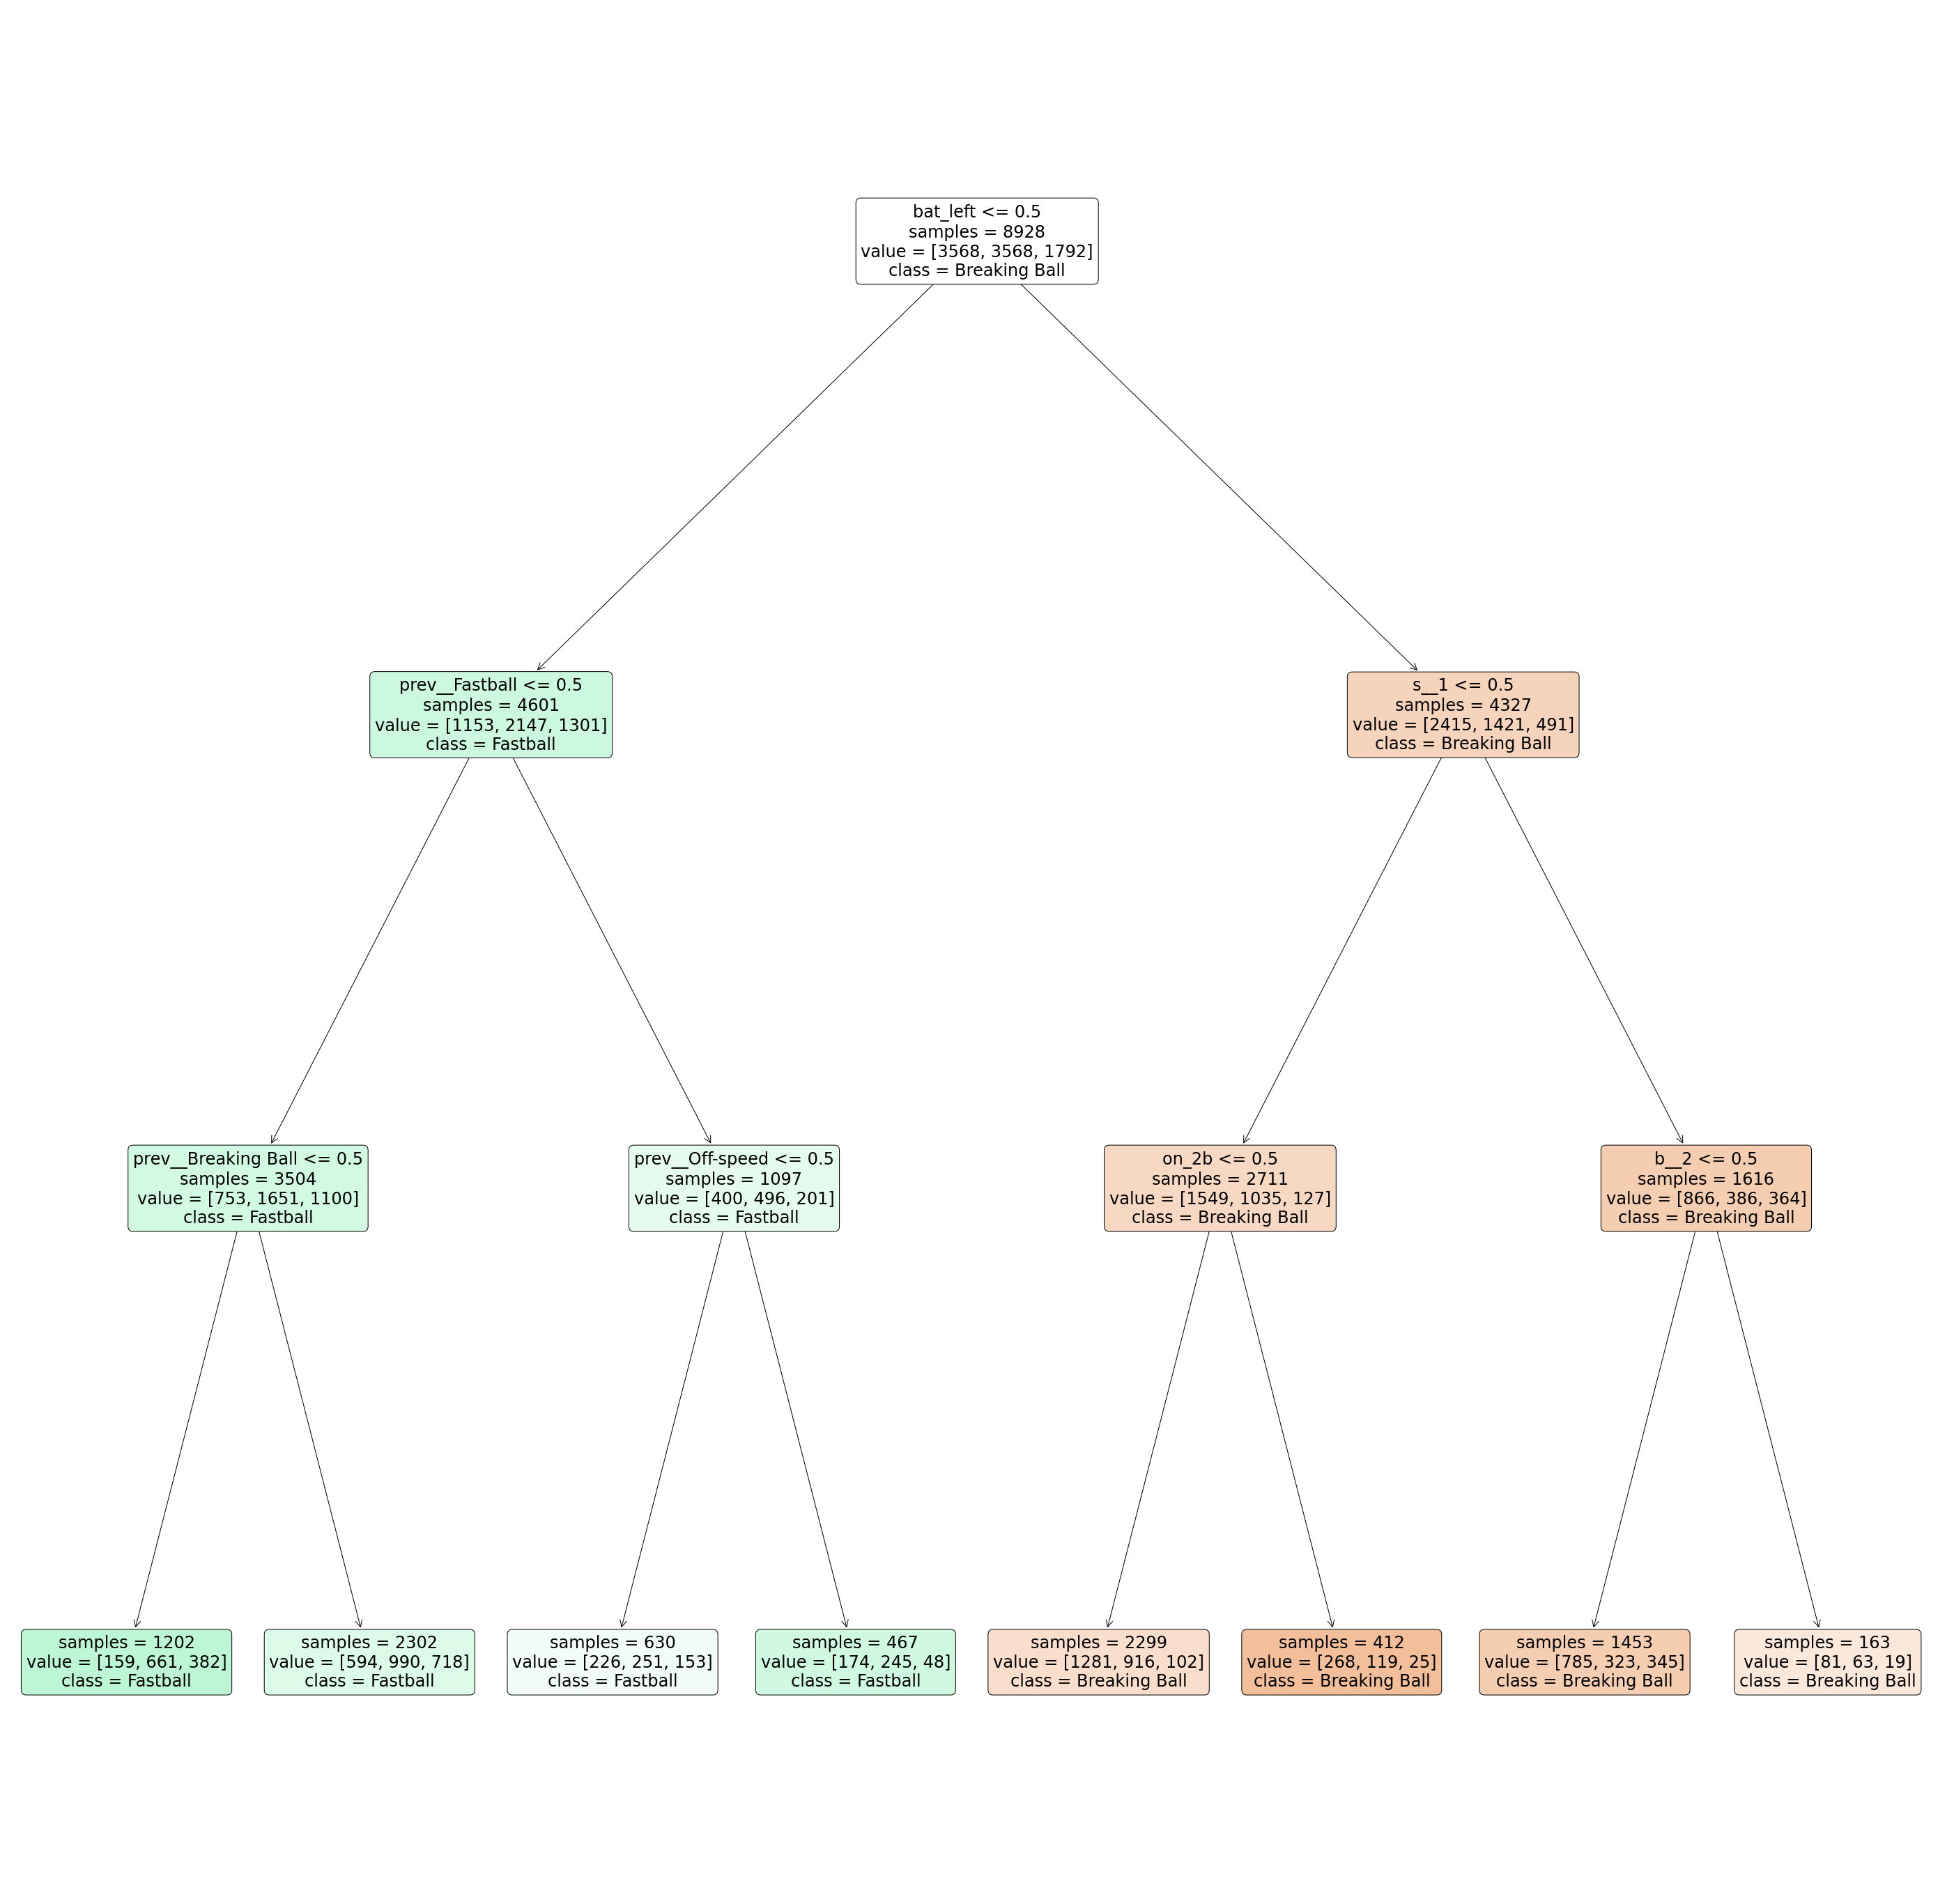

In [163]:
from sklearn.tree import plot_tree
plt.figure(figsize = (50, 50))
plot_tree(tree, 
          feature_names=X.columns, 
          class_names=xnames.values,
          rounded=True,
          impurity=False,
          filled=True)
plt.show()

***

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
pens = ['l1', 'l2']
c_vals = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
logreg = LogisticRegression(solver = 'lbfgs')

params = {'C':c_vals, 'penalty':pens}

# Instatiate grid search using my tree model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(logreg, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.0s finished


LogisticRegression(C=0.001)

In [245]:
logit = LogisticRegression(C = 0.001, solver = 'lbfgs').fit(X_train, y_pitch)
logit.score(X_test, y_test_copy)

0.5437280187573271

In [246]:
y_pred = logit.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

(array(['Breaking Ball', 'Fastball', 'Off-speed'], dtype=object),
 array([1992, 2245,   28], dtype=int64))

In [253]:
report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.59      0.62      2478
    Off-speed       0.29      0.01      0.03       597

     accuracy                           0.54      4265
    macro avg       0.45      0.44      0.39      4265
 weighted avg       0.54      0.54      0.51      4265

